In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier, DMatrix, train, cv

In [2]:
dados = pd.read_csv("train.csv", delimiter=',')

In [3]:
dados

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [4]:
#Verificando os tipos de dados existentes na base
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
#Verificando se ha valores missing padrao (None, NaN) na base como um todo 
dados.isnull().sum().sum()

0

In [6]:
#Separa a base em 70% treino e 30% teste, estratificada pela TARGET, uma vez que ela nao tem uma proporcao equilibrada na base
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dados, test_size=0.3,stratify=dados['TARGET'],random_state=42)
train_set.shape, test_set.shape

((53214, 371), (22806, 371))

In [7]:
df = pd.DataFrame(train_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train_set.shape[0]
df

,TARGET,Percentage
0,51108,96.042395
1,2106,3.957605


In [8]:
df = pd.DataFrame(test_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/test_set.shape[0]
df

,TARGET,Percentage
0,21904,96.0449
1,902,3.9551


In [9]:
#REMOVER COLUNAS IGUAIS
features = train_set.drop(['TARGET','ID'],axis=1)
corr_matrix = features.corr()
corr_matrix.shape

(369, 369)

In [10]:
#como a matriz de correlacao se repete na diagonal superior e inferior, escolhi uma delas 
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool)) 

In [11]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] == 1)] 
print(to_drop)

['ind_var18', 'ind_var26', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var32', 'ind_var37', 'ind_var39', 'num_var18', 'num_var26', 'num_var25', 'num_var29_0', 'num_var29', 'num_var32', 'num_var37', 'num_var39', 'saldo_var29', 'delta_num_aport_var33_1y3', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3', 'delta_num_venta_var44_1y3']


In [12]:
print(len(to_drop))

25


In [13]:
features_1 = features.drop(to_drop, axis=1)
features_1.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [14]:
#REMOVER VARIAVEIS CONSTANTES, OU SEJA, COM VARIANCIA ZERO

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(features_1)  # fit encontra variaveis com variancia zero
#get_support() eh um vetor que indica quais variaveis NAO tem variancia zero
to_drop_2 = [column for column in features_1.columns if column not in features_1.columns[sel.get_support()]] 
print(to_drop_2)

['ind_var2_0', 'ind_var2', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var34_0', 'ind_var34', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var13_medio_0', 'num_var13_medio', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var34_0', 'num_var34', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var13_medio', 'saldo_var28', 'saldo_var27', 'saldo_var34', 'saldo_var41', 'saldo_var46', 'delta_imp_amort_var34_1y3', 'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_amort_var34_ult1', 'imp_reemb_var13_hace3', 'imp_reemb_var17_hace3', 'imp_reemb_var33_hace3', 'imp_reemb_var33_ult1', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_meses_var13_medio_ult3', 'num_reemb_var13_hace3', 'num_reemb_var17_hace3', 'num_reemb_var33_hace3', 'num_reemb_var33_ult1', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo

In [15]:
print(len(to_drop_2))

57


In [16]:
features_2= features_1.drop(to_drop_2, axis=1)
features_2.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [17]:
features_2.shape

(53214, 287)

In [18]:
dict = {'full': features_2.columns}
colunas = pd.DataFrame(dict)

colunas['abv'] = colunas['full'].str.slice(0,3)
colunas

,full,abv
0,var3,var
1,var15,var
2,imp_ent_var16_ult1,imp
3,imp_op_var39_comer_ult1,imp
4,imp_op_var39_comer_ult3,imp
...,...,...
282,saldo_medio_var44_hace2,sal
283,saldo_medio_var44_hace3,sal
284,saldo_medio_var44_ult1,sal
285,saldo_medio_var44_ult3,sal


In [19]:
colunas.groupby('abv').count()

,full
abv,
del,15
imp,40
ind,54
num,115
sal,58
var,5


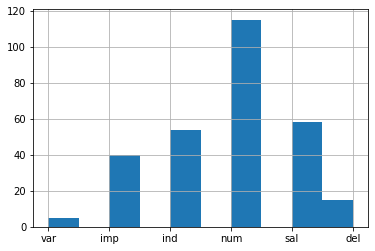

In [20]:
colunas.abv.hist()

In [21]:
colunas[colunas['abv'] == 'var']['full']

0       var3
1      var15
146    var36
193    var21
286    var38
Name: full, dtype: object

In [22]:
#TENTAR DETERMINAR SE AS VARIAVEIS SAO BINARIAS, CATEGORICAS OU CONTINUAS

#PRIMEIRO VERIFICOU-SE A QUANTIDADE DE DOMINIOS DE CADA VARIAVEL DA BASE E TENTOU-SE AGRUPAR POR QUANTIDADE DE DOMINIOS
#BINARIAS: 2 DOMINIOS
#CATEGORICAS ATE 10 DOMINIOS: DE 3 A 10 DOMINIOS OU VARS COM INICIO DO NOME DA VARIAVEL NUM (TODAS ELAS PARECEM TER
# APENAS VALORES INTEIROS ATRAVES DO DESCRIBE), REMOVENDO VARIAVEIS COM VALORES NAO INTEIROS (ELAS SE TORNAM CONTINUAS)
#CONTINUAS: FOI FEITO UM TRABALHO DE VERIFICAR QUAL ERA UMA QUANTIDADE MINIMA DE DOMINIOS NECESSARIOS PARA A VARIAVEL
# DEIXAR DE SER CATEGORICA E SE TORNAR CONTINUA, INICIOU-SE O TESTE VERIFICANDO SE A QUANTIDADE DE DOMINIOS ERA MAIOR
# QUE N/2 E FOI-SE DIMINUINDO E VERIFICANDO QUAIS VARIAVEIS ALI TINHAM NOMES PARECIDOS, ALEM DE VERIFICAR SE O DESCRIBE
# MOSTRAVA VALORES QUEBRADOS OU VALORES INTEIROS.
#  VARS COM INICIO DO NOME DA VARIAVEL SALDO, IMP OU DELTA (-1 A 1)


#VETORES DE TESTE
vars_bin = []
vars_cat10 = []
vars_cont = []

vars_bin = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) == 2]

vars_cat10 = [columns for columns in features_2.columns 
              if columns not in vars_bin
              and len(features_2[columns].value_counts()) <= 10
              or columns in colunas[colunas['abv'] == 'var']['full']]
#vars_cont = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) > 10 and len(features_2[columns].value_counts()) > int((features_2.shape[0])/500)]
vars_cont = [columns for columns in features_2.columns 
             if columns not in vars_bin 
             and columns not in vars_cat10]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10))
print('#Continuas',len(vars_cont))
#APARENTEMENTE:
#BINARIAS: com 2 categorias
#CATEGORICAS: com 3 categorias
#CONTINUAS: SALDO ou IMP ou DELTA (-1 A 1)
#CATEGORICAS: NUM ou ate 10 categorias


#Binarias 80
#Ate 10 categorias 78
#Continuas 129


In [23]:
#VERIFICA SE AS VARIAVEIS CONSIDERADAS CATEGORICAS SAO INTEIROS NAO NEGATIVOS, CASO CONTRARIO, CHAMAR DE CONTINUAS

var_cat_true = []

var_cat_true = [columns for columns in features_2[vars_cat10].columns 
                if np.array_equal(features_2[columns], features_2[columns].astype(int))
                and np.array_equal(features_2[columns], abs(features_2[columns]))]
print(len(var_cat_true))

60


In [24]:
vars_to_cont = []

vars_to_cont = [columns for columns in features_2[vars_cat10].columns if columns not in var_cat_true]
print(len(vars_to_cont))

18


In [25]:
vars_cont_2 = []
vars_cat10_2 = []

vars_cont_2 = [columns for columns in features_2.columns if columns in vars_cont or columns in vars_to_cont]
vars_cat10_2 = [columns for columns in features_2[vars_cat10].columns if columns not in vars_to_cont]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_2))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 60
#Continuas 147


In [26]:
vars_cat10_2

['num_var1_0',
 'num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14_0',
 'num_var14',
 'num_var17',
 'num_var24_0',
 'num_var24',
 'num_var26_0',
 'num_var25_0',
 'num_op_var40_hace3',
 'num_var30_0',
 'num_var30',
 'num_var31',
 'num_var32_0',
 'num_var33_0',
 'num_var33',
 'num_var39_0',
 'num_var40_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'var36',
 'imp_aport_var33_ult1',
 'num_aport_var13_hace3',
 'num_aport_var13_ult1',
 'num_aport_var17_hace3',
 'num_aport_var17_ult1',
 'num_aport_var33_hace3',
 'num_aport_var33_ult1',
 'num_var7_recib_ult1',
 'num_compra_var44_hace3',
 'num_compra_var44_ult1',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var13_largo_ult3',
 'num_meses_var17_ult3',
 'num_meses_var29_ult3',
 'num_meses_var33_ult3',
 'num_meses_v

In [27]:
#FAZER UM TESTE QUI-QUADRADO ENTRE AS VARIAVEIS CAEGORICAS E A TARGET PARA VERIFICAR A ASSOCIACAO ENTRE ELAS
#Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados
# desviam dos valores observados.


# Importar metrica
from sklearn.feature_selection import chi2
# Calculando Chi-Squared
chi_scores = chi2(train_set[vars_cat10_2],train_set['TARGET'])
# Colocando label nos resultados para posterior plot
scores = pd.Series(chi_scores[0], index=vars_cat10_2)
pvalues = pd.Series(chi_scores[1], index=vars_cat10_2)

# Results
teste_chi = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})
teste_chi['associacao'] = teste_chi[teste_chi['p-Value'] <= 0.05]['p-Value']
teste_chi

,Chi2,p-Value,associacao
num_var1_0,2.056941,1.515141e-01,NaN
num_var4,245.491116,2.497193e-55,2.497193e-55
num_var5_0,7.597927,5.843544e-03,5.843544e-03
num_var5,987.652698,8.672433e-217,8.672433e-217
num_var8_0,375.266455,1.335196e-83,1.335196e-83
num_var12_0,85.862875,1.928557e-20,1.928557e-20
num_var12,156.720950,5.890152e-36,5.890152e-36
num_var13_0,240.497758,3.063180e-54,3.063180e-54
num_var13_corto_0,168.619793,1.481237e-38,1.481237e-38
num_var13_corto,171.138710,4.173166e-39,4.173166e-39


In [28]:
to_drop_3 = []
to_drop_3 = [columns for columns in teste_chi[teste_chi['p-Value'] > 0.05].index]
print(len(to_drop_3))

20


In [29]:
vars_cat10_3 = []

vars_cat10_3 = [columns for columns in features_2[vars_cat10_2].columns if columns not in to_drop_3]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_3))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 40
#Continuas 147


In [30]:
vars_cat10_3

['num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14',
 'num_var24_0',
 'num_var24',
 'num_var26_0',
 'num_var25_0',
 'num_var30_0',
 'num_var30',
 'num_var33_0',
 'num_var39_0',
 'num_var41_0',
 'num_var42',
 'var36',
 'imp_aport_var33_ult1',
 'num_aport_var13_hace3',
 'num_aport_var13_ult1',
 'num_aport_var17_ult1',
 'num_compra_var44_ult1',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var13_largo_ult3',
 'num_meses_var17_ult3',
 'num_op_var40_efect_ult1',
 'num_op_var40_efect_ult3',
 'num_reemb_var17_ult1',
 'num_sal_var16_ult1',
 'num_venta_var44_ult1']

In [31]:
features_3 = features_2.drop(to_drop_3, axis=1)
features_3.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [ ]:
#VERIFICAR SE AS VARIAVEIS SAO ORDINAIS EM RELACAO A TARGET, SENAO, FAZER ENCODING OOOOU PARAR AQUI????

In [ ]:
#CRIAR VARIAVEL QUE IDENTIFICA OS CLIENTES QUE ESTAO NO RANGE DOS OUTLIERS EM TODAS AS VARIAVEIS

In [ ]:
#FEATURE SELECTION - RANDOM FOREST - GRID SEARCH

In [32]:
#Separa X e Y de treino
x_train = []
y_train = []
x_train = train_set[features_3.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 267), (53214,))

In [33]:
#Cria var aleatoria

x_train['random_var'] = np.random.rand(x_train.shape[0])

/Users/brunaoliveira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
#Como os dados nao sao balanceados
#Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost
# sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty
# on misclassifying the minority class.
#class weight = balanced -> This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of
# ‘balanced‘ can be provided to automatically use the inverse weighting from the training dataset, giving focus to the
# minority class.
#class_weight='balanced_subsample' -> Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class
# distribution in the data sample will be different for each tree.
#As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample,
# instead of the entire training dataset.

rnd_clf = RandomForestClassifier(n_estimators = 10, class_weight='balanced_subsample',random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring='roc_auc', cv=10) #para classificacao o cv ja eh estratificado pela target

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.682


In [62]:
#Faz Grid Search para ver se teriamos algum valor melhor para os hiperparametros
#Foi testado 'n_estimators': [10,30,50] E 'max_depth': range(5,50,10) E 'max_features': ['sqrt','log2'] -> best = 50, 5, sqrt
#Foi testado 'n_estimators': [30,50,100] E 'max_depth': range(5,20,10) E 'max_features': ['sqrt','log2'] -> best = 100, 5, sqrt

grid_param = {
    'n_estimators': [50,100,150],
    'criterion': ['gini'], #default
    'max_depth': range(5,20,10),
    'max_features': ['sqrt','log2'],
    'class_weight':['balanced_subsample']
}

rnd_clf = RandomForestClassifier()

grid_search = GridSearchCV(rnd_clf,grid_param,scoring='roc_auc',cv=10)

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [63]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [64]:
grid_search.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 150}

In [65]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

0.7984600317320918 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
0.7986318114046157 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
0.7989328538157875 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150}
0.785138318435836 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
0.7872499658485306 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.7879911067327963 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 150}
0.7793716168174594 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 50}
0.7815371410230372 {'cl

In [36]:
rnd_clf = RandomForestClassifier(criterion = 'gini',
 max_depth = 5,
 max_features = 'sqrt',
 n_estimators = 150,
 class_weight = 'balanced_subsample', random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring='roc_auc', cv=10) #para classificacao o cv ja eh estratificado pela target

print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.799


In [37]:
rnd_clf.fit(x_train,y_train)

feature_scores = pd.Series(rnd_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance.csv',header=False)

feature_scores

var15                       0.124519
saldo_var30                 0.076736
saldo_var42                 0.062088
saldo_var5                  0.048948
saldo_medio_var5_ult1       0.047978
                              ...   
num_var20                   0.000000
num_op_var40_hace2          0.000000
num_op_var40_ult1           0.000000
num_op_var40_ult3           0.000000
num_trasp_var33_out_ult1    0.000000
Length: 268, dtype: float64

In [38]:
feature_scores.get(key='random_var')

0.001894674221158761

In [39]:
(feature_scores <= feature_scores.get(key='random_var')).sum()

207

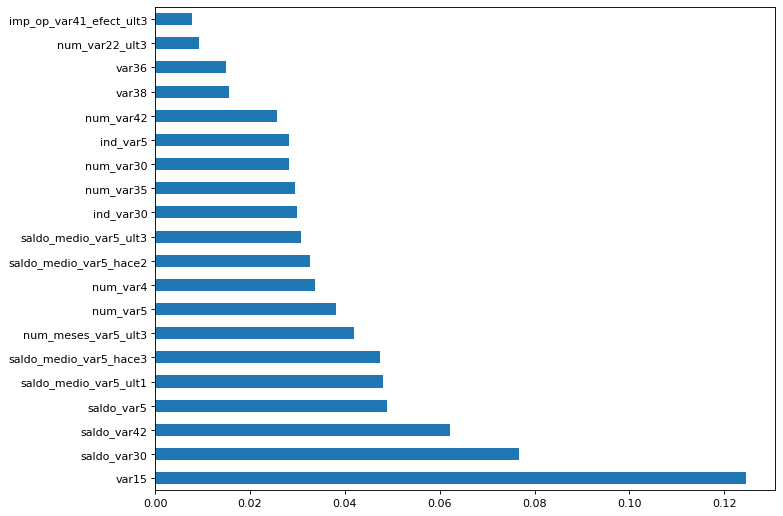

In [40]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importance = pd.Series(rnd_clf.feature_importances_, index= x_train.columns)

feat_importance.nlargest(20).plot(kind='barh')

In [41]:
to_drop_4 = []
to_drop_4 = feature_scores.loc[lambda x: x <= feature_scores.get(key='random_var')].index[1:]

In [42]:
features_4 = features_3.drop(to_drop_4, axis=1)
features_4.head()

,var15,imp_op_var39_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,ind_var5,ind_var8_0,...,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var12_hace2,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_ult1,var38
61553,38,209.7,450.0,720.0,552.0,450.0,720.0,552.0,1,0,...,129.18,12.60,176.07,105.96,51089.19,63972.99,57531.09,0.0,0.0,175887.150000
6865,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,...,1.50,0.72,1.50,1.23,0.00,0.00,0.00,0.0,0.0,111297.030000
847,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,...,3.00,0.72,3.00,2.25,0.00,0.00,0.00,0.0,0.0,117310.979016
40817,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,80805.900000
71630,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,...,91.98,68.28,120.00,93.42,0.00,0.00,0.00,0.0,0.0,124585.620000


# Treino do Modelo

In [43]:
#Separa X e Y de treino
x_train = train_set[features_4.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 61), (53214,))

In [55]:
#Separa X e Y de treino
x_test = test_set[features_4.columns]
y_test = test_set['TARGET']
x_test.shape, y_test.shape

((22806, 61), (22806,))

#### Define Funcao de Lucro para Maximizar

In [85]:
#funcao que verifica se o lucro do modelo se aproxima do lucro max que poderia ter

def funcao_lucro(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred).ravel().tolist()
    fp = cm[1]
    tp = cm[3]

    lucro_max = sum(y_true)*90
    
    f_lucro = ((-10*fp)+(90*tp))/lucro_max

    return f_lucro

#### Lucro Maximo (100% acerto)

In [45]:
LM = sum(y_train)*90
print('Lucro Maximo: %.2f' % LM)

Lucro Maximo: 189540.00


#### Acao para todos os clientes

In [87]:
y_acao = pd.Series(np.ones(len(y_train)),name='TARGET',dtype=int)

auc = roc_auc_score(y_train, y_acao.to_list())
print('ROC AUC: %.3f' % auc)
LR = funcao_lucro(y_train,y_acao.to_list())
print('Lucro Relativo: %.3f' % LR)
print('Lucro Total: %.2f' % (LR*LM))

ROC AUC: 0.500
Lucro Relativo: -1.696
Lucro Total: -321540.00


### XGBoost

In [ ]:
#Gerar um modelo com Gradiente Boosting
#implementacao otimizada: XGBoost - rapido, escalonavel e portatil

In [58]:
# dtrain_clf = DMatrix(x_train,y_train)
# dtest_clf = DMatrix(x_test,y_test)

# #Como os dados nao sao balanceados, usei scale_pos_weight
# params = {"objective": "binary:logistic", 'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1)}

# #Faz cross val para avaliar a performance de forma mais realista
# cv_results = cv(
#    params, 
#    dtrain_clf,
#    num_boost_round=100,
#    nfold=5,
#    early_stopping_rounds=10,
#    metrics = 'auc',
#    seed = 42
# )

# best_score = max(cv_results['test-auc-mean'])
# print('ROC AUC: %.3f' % best_score)

AUC: 0.828


In [ ]:
#verificar quantos rounds(modelos) foram necessarios para chegar no maximo auc
# cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.845953,0.001765,0.814589,0.006176
1,0.858188,0.001286,0.821193,0.007878
2,0.865751,0.001758,0.824753,0.007102
3,0.870436,0.002402,0.827444,0.004832
4,0.874123,0.001788,0.828083,0.004499
5,0.878301,0.001755,0.828249,0.004625


In [86]:
#Treinando e Testando o modelo base
XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

ROC AUC: 0.895
ROC AUC Teste: 0.729
Lucro Relativo: 0.562
Lucro Relativo Teste: 0.208
Lucro Total: 106550.00
Lucro Total Teste: 39341.57


In [ ]:
#Tuna hiperparametros
#Faz grid search para selecionar os melhores hiperparametros
#Feature selection
#grafico de aumento de vars por aumento de lucro (menor complexidade vs maior lucro)

In [88]:
#Faz Random Search para ver se teriamos algum valor melhor para os hiperparametros
#Random Search eh melhor para tunar hiperparametros com XGBoost, pois ele considera algumas combinacoes aleatorias de parametros e nao
# todas (como o Grid Search). Logo, como o XGBoost faz modelos sequenciais e, consequentemente, demora mais, melhor usar o Random. 
#https://xgboost.readthedocs.io/en/stable/parameter.html

#Fiz 'learning_rate': np.arange(0.1,1.01,0.2) -> 0.1

XGB_grid_param = {
    'n_estimators': range(10,100,10),
    'max_depth': range(3,21,3), #default 6
    'learning_rate': [0.0001,0.001,0.01,0.1,0.3,0.6], #default 0,3
    'subsample': np.arange(0.25,1.01,0.25), #default 1
}

In [ ]:
random_search = RandomizedSearchCV(estimator=XGB, 
                           param_distributions=XGB_grid_param,
                           n_iter=48,
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           cv=5)

random_search.fit(x_train,y_train)

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
random_search.best_params_

{'subsample': 1.0, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.1}

In [ ]:
random_search.cv_results_

{'subsample': 1.0, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.1}

In [89]:
lucro = make_scorer(funcao_lucro, greater_is_better=True)

random_search = RandomizedSearchCV(estimator=XGB, 
                           param_distributions=XGB_grid_param,
                           n_iter=48,
                           scoring=lucro, 
                           n_jobs=-1, 
                           cv=5)

random_search.fit(x_train,y_train)

In [ ]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [ ]:
random_search.best_params_

{'subsample': 1.0, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.1}

In [ ]:
random_search.cv_results_

{'subsample': 1.0, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.1}

In [79]:
# these are the evaluation sets
# valX = x_train 
# valY = y_train

# fit_params={"early_stopping_rounds":10,
#             "eval_metric" : "auc", 
#             "eval_set" : [[valX, valY]]}

# random_search = RandomizedSearchCV(estimator=XGB, 
#                            param_distributions=XGB_grid_param,
#                            n_iter=48,
#                            scoring='roc_auc', 
#                            n_jobs=-1, 
#                            cv=5)

# random_search.fit(x_train,y_train, **fit_params)

/Users/brunaoliveira/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/Users/brunaoliveira/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-mae:0.48558
[1]	validation_0-mae:0.47254
[2]	validation_0-mae:0.45994
[3]	validation_0-mae:0.44879
[4]	validation_0-mae:0.43823
[5]	validation_0-mae:0.42935
[6]	validation_0-mae:0.42078
[7]	validation_0-mae:0.41339
[8]	validation_0-mae:0.40546
[9]	validation_0-mae:0.39944
[10]	validation_0-mae:0.39368
[11]	validation_0-mae:0.38899
[12]	validation_0-mae:0.38452
[13]	validation_0-mae:0.38030
[14]	validation_0-mae:0.37670
[15]	validation_0-mae:0.37338
[16]	validation_0-mae:0.37010
[17]	validation_0-mae:0.36762
[18]	validation_0-mae:0.36478
[19]	validation_0-mae:0.36129
[20]	validation_0-mae:0.35854
[21]	validation_0-mae:0.35527
[22]	validation_0-mae:0.35296
[23]	validation_0-mae:0.35139
[24]	validation_0-mae:0.35037
[25]	validation_0-mae:0.34882
[26]	validation_0-mae:0.34658
[27]	validation_0-mae:0.34471
[28]	validation_0-mae:0.34317
[29]	validation_0-mae:0.34138
[30]	validation_0-mae:0.34055
[31]	validation_0-mae:0.33942
[32]	validation_0-mae:0.33836
[33]	validation_0-ma

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,...
                                           predictor=None, random_state=42,
                                           reg_alpha=None, ...),
                   iid='warn', n_iter=48,

In [80]:
# random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [81]:
# random_search.best_params_

{'subsample': 0.75, 'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.1}

In [83]:
XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   n_estimators = 70,
   max_depth = 3,
   learning_rate = 0.1,
   subsample = 1,
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % (-1*LR))
print('Lucro Relativo Teste: %.3f' % (-1*LR_test))
print('Lucro Total: %.2f' % ((-1*LR)*LM))
print('Lucro Total Teste: %.2f' % ((-1*LR_test)*LM))

ROC AUC: 0.778
ROC AUC Teste: 0.769
Lucro Relativo: 0.163
Lucro Relativo Teste: 0.141
Lucro Total: 30880.00
Lucro Total Teste: 26640.20


In [ ]:
rnd_clf.fit(x_train,y_train)

feature_scores = pd.Series(rnd_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance.csv',header=False)

feature_scores

var15                       0.121741
saldo_var30                 0.076560
saldo_var42                 0.062785
saldo_var5                  0.050800
saldo_medio_var5_ult1       0.049382
                              ...   
ind_var7_emit_ult1          0.000000
num_var17_0                 0.000000
num_var18_0                 0.000000
num_var20                   0.000000
imp_trasp_var17_in_hace3    0.000000
Length: 268, dtype: float64

In [13]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(x_treino)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [14]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

313

In [16]:
# print the constant features
print(
    len([
        x for x in x_treino.columns
        if x not in x_treino.columns[sel.get_support()]
    ]))

[x for x in x_treino.columns if x not in x_treino.columns[sel.get_support()]]

57


['ind_var2_0',
 'ind_var2',
 'ind_var13_medio_0',
 'ind_var13_medio',
 'ind_var27_0',
 'ind_var28_0',
 'ind_var28',
 'ind_var27',
 'ind_var34_0',
 'ind_var34',
 'ind_var41',
 'ind_var46_0',
 'ind_var46',
 'num_var13_medio_0',
 'num_var13_medio',
 'num_var27_0',
 'num_var28_0',
 'num_var28',
 'num_var27',
 'num_var34_0',
 'num_var34',
 'num_var41',
 'num_var46_0',
 'num_var46',
 'saldo_var13_medio',
 'saldo_var28',
 'saldo_var27',
 'saldo_var34',
 'saldo_var41',
 'saldo_var46',
 'delta_imp_amort_var34_1y3',
 'delta_imp_reemb_var33_1y3',
 'delta_num_reemb_var33_1y3',
 'imp_amort_var18_hace3',
 'imp_amort_var34_hace3',
 'imp_amort_var34_ult1',
 'imp_reemb_var13_hace3',
 'imp_reemb_var17_hace3',
 'imp_reemb_var33_hace3',
 'imp_reemb_var33_ult1',
 'imp_trasp_var17_out_hace3',
 'imp_trasp_var33_out_hace3',
 'num_var2_0_ult1',
 'num_var2_ult1',
 'num_meses_var13_medio_ult3',
 'num_reemb_var13_hace3',
 'num_reemb_var17_hace3',
 'num_reemb_var33_hace3',
 'num_reemb_var33_ult1',
 'num_trasp_var1

In [10]:
for i in df1.columns:
    print(i)

ID
var3
var15
imp_ent_var16_ult1
imp_op_var39_comer_ult1
imp_op_var39_comer_ult3
imp_op_var40_comer_ult1
imp_op_var40_comer_ult3
imp_op_var40_efect_ult1
imp_op_var40_efect_ult3
imp_op_var40_ult1
imp_op_var41_comer_ult1
imp_op_var41_comer_ult3
imp_op_var41_efect_ult1
imp_op_var41_efect_ult3
imp_op_var41_ult1
imp_op_var39_efect_ult1
imp_op_var39_efect_ult3
imp_op_var39_ult1
imp_sal_var16_ult1
ind_var1_0
ind_var1
ind_var2_0
ind_var2
ind_var5_0
ind_var5
ind_var6_0
ind_var6
ind_var8_0
ind_var8
ind_var12_0
ind_var12
ind_var13_0
ind_var13_corto_0
ind_var13_corto
ind_var13_largo_0
ind_var13_largo
ind_var13_medio_0
ind_var13_medio
ind_var13
ind_var14_0
ind_var14
ind_var17_0
ind_var17
ind_var18_0
ind_var18
ind_var19
ind_var20_0
ind_var20
ind_var24_0
ind_var24
ind_var25_cte
ind_var26_0
ind_var26_cte
ind_var26
ind_var25_0
ind_var25
ind_var27_0
ind_var28_0
ind_var28
ind_var27
ind_var29_0
ind_var29
ind_var30_0
ind_var30
ind_var31_0
ind_var31
ind_var32_cte
ind_var32_0
ind_var32
ind_var33_0
ind_var33


In [14]:
#verificando a proporcao TARGET = 1 / TARGET = 0
x = df1['TARGET']

x.sum()

3008

In [15]:
3008/76020

0.0395685345961589

In [3]:
from sklearn.feature_selection import RFE
!pip install xgboost
from xgboost import XGBClassifier

In [6]:

from sklearn.model_selection import train_test_split

In [10]:
x_treino, x_teste, y_treino, y_teste = train_test_split(df1,df1['TARGET'],test_size=0.3,stratify=df1['TARGET'],random_state=42)

In [15]:
y_teste.sum()

902

In [16]:
y_treino.sum()

2106

In [26]:
model = XGBClassifier().fit(x_treino.drop(['ID','TARGET'],axis=1),y_treino)

In [27]:
#Selecao das features com RFE
n_features = 40
rfe = RFE(estimator=model,n_features_to_select=n_features)

In [28]:
alguma_coisa = rfe.fit_transform(x_treino.drop(['ID','TARGET'],axis=1),y_treino)

In [30]:
#tras o indice das features que ele escolheu
indices = rfe.get_support(indices=True)

In [29]:
#usar so as features selecionadas para retreinar o modelo
#testar os ks de treino vs teste
#verificar a distancia entre os ks, se precisar, alterar os parametros